# Analiza zbioru

In [2]:
import re
import pandas as pd

def load_dataset(name: str) -> pd.DataFrame:
    def split_rel(rel: str):
        splitted = re.split(r'[-\(\,\)]', rel)
        try:
            t0, t1, e0, e1, *_ = splitted
            rel_args = (t0, t1)
            ent_args = (e0, e1)
        except ValueError as e:
            if 'expected at least 4, got 1' in e.args[0]:
                rel_args = (splitted[0],)
                ent_args = (None, None)
            else:
                raise Exception('arguments exception') from e
        
        return {
            'arg1_rel': rel_args[0],
            'arg2_rel': rel_args[1] if len(rel_args) > 1 else rel_args[0],
            'arg1': ent_args[0],
            'arg2': ent_args[1]
        }

    with open(name) as f:
        lines = f.readlines()
        text = [l.split('\t')[1] for l in lines[::4]]
        rel =  [split_rel(l.strip()) for l in lines[1::4]]

    rel = pd.DataFrame(rel)
    text = pd.DataFrame([t[1:-2] for t in text], columns=['text'])

    df = pd.merge(rel, text, left_index=True, right_index=True)
    return df

df_train = load_dataset('../../../data/semeval/TRAIN_FILE.TXT')
df_test = load_dataset('../../../data/semeval/TEST_FILE.TXT')

Relacja składa się z typu encji skłądających się na argumenty relacji. Encje są oznaczone w tekście wykorzystując znaczniki `html`. Każda z encji występuje tylko raz w tekście.

In [5]:
df_train

,arg1_rel,arg2_rel,arg1,arg2,text
0,Component,Whole,e2,e1,The system as described above has its greatest...
1,Other,Other,None,None,The <e1>child</e1> was carefully wrapped and b...
2,Instrument,Agency,e2,e1,The <e1>author</e1> of a keygen uses a <e2>dis...
3,Other,Other,None,None,A misty <e1>ridge</e1> uprises from the <e2>su...
4,Member,Collection,e1,e2,The <e1>student</e1> <e2>association</e2> is t...
...,...,...,...,...,...
7995,Other,Other,None,None,When the <e1>notice</e1> is sent by <e2>fax</e...
7996,Entity,Origin,e1,e2,The <e1>herbicide</e1> is derived from a natur...
7997,Entity,Destination,e1,e2,"To test this, we placed a kitchen <e1>match</e..."
7998,Other,Other,None,None,The farmers and city officials in the region h...


In [6]:
df_test

,arg1_rel,arg2_rel,arg1,arg2,text
0,Message,Topic,e1,e2,The most common <e1>audits</e1> were about <e2...
1,Product,Producer,e2,e1,The <e1>company</e1> fabricates plastic <e2>ch...
2,Instrument,Agency,e2,e1,The school <e1>master</e1> teaches the lesson ...
3,Entity,Destination,e1,e2,The suspect dumped the dead <e1>body</e1> into...
4,Cause,Effect,e2,e1,Avian <e1>influenza</e1> is an infectious dise...
...,...,...,...,...,...
2712,Instrument,Agency,e2,e1,"After seating all the idols, which itself take..."
2713,Product,Producer,e1,e2,The minister attributed the slow production of...
2714,Component,Whole,e2,e1,The <e1>umbrella</e1> <e2>frame</e2> is provid...
2715,Product,Producer,e1,e2,Manos: The Hands of Fate is a low-budget horro...


## Badanie zbalansowania danych

In [19]:
import matplotlib.pyplot as plt
from itertools import repeat

def draw_dist(dataset: pd.DataFrame):
    def draw_col(dataset):
        x = dataset.value_counts()
        mean = x.mean()
        upper, lower = (x.mean() + x.std(), x.mean() - x.std())
        double_upper, double_lower = (upper + x.std(), lower - x.std())

        plt.plot(list(repeat(double_upper, len(x))), color='violet', linestyle='dashed', linewidth=2, dashes=(10,10))
        plt.plot(list(repeat(upper, len(x))), color='blue', linestyle='dashed', linewidth=3, dashes=(5,10))
        plt.plot(list(repeat(mean, len(x))), color='red', linewidth=4)
        plt.plot(list(repeat(lower, len(x))), color='blue', linestyle='dashed', linewidth=3, dashes=(5,10))
        plt.plot(list(repeat(double_lower, len(x))), color='violet', linestyle='dashed', linewidth=2, dashes=(10,10))


        x\
        .plot\
        .bar(figsize=(20,20))
        plt.show()

    
    draw_col(dataset['arg1_rel'])
    draw_col(dataset['arg2_rel'])
    draw_col(dataset['arg1_rel'] + '-' + df_train['arg2_rel'])

Danie nie są zbalansowane ani w zbiorze treningowym, ani testowym. Dla danych treningowych największy problem można mieć z relacją `Other`, która przekracza `2σ` w nadmiarze. Dane mocno odbiegają od średniej, model może mieć problem z nauczeniem się wzorców.

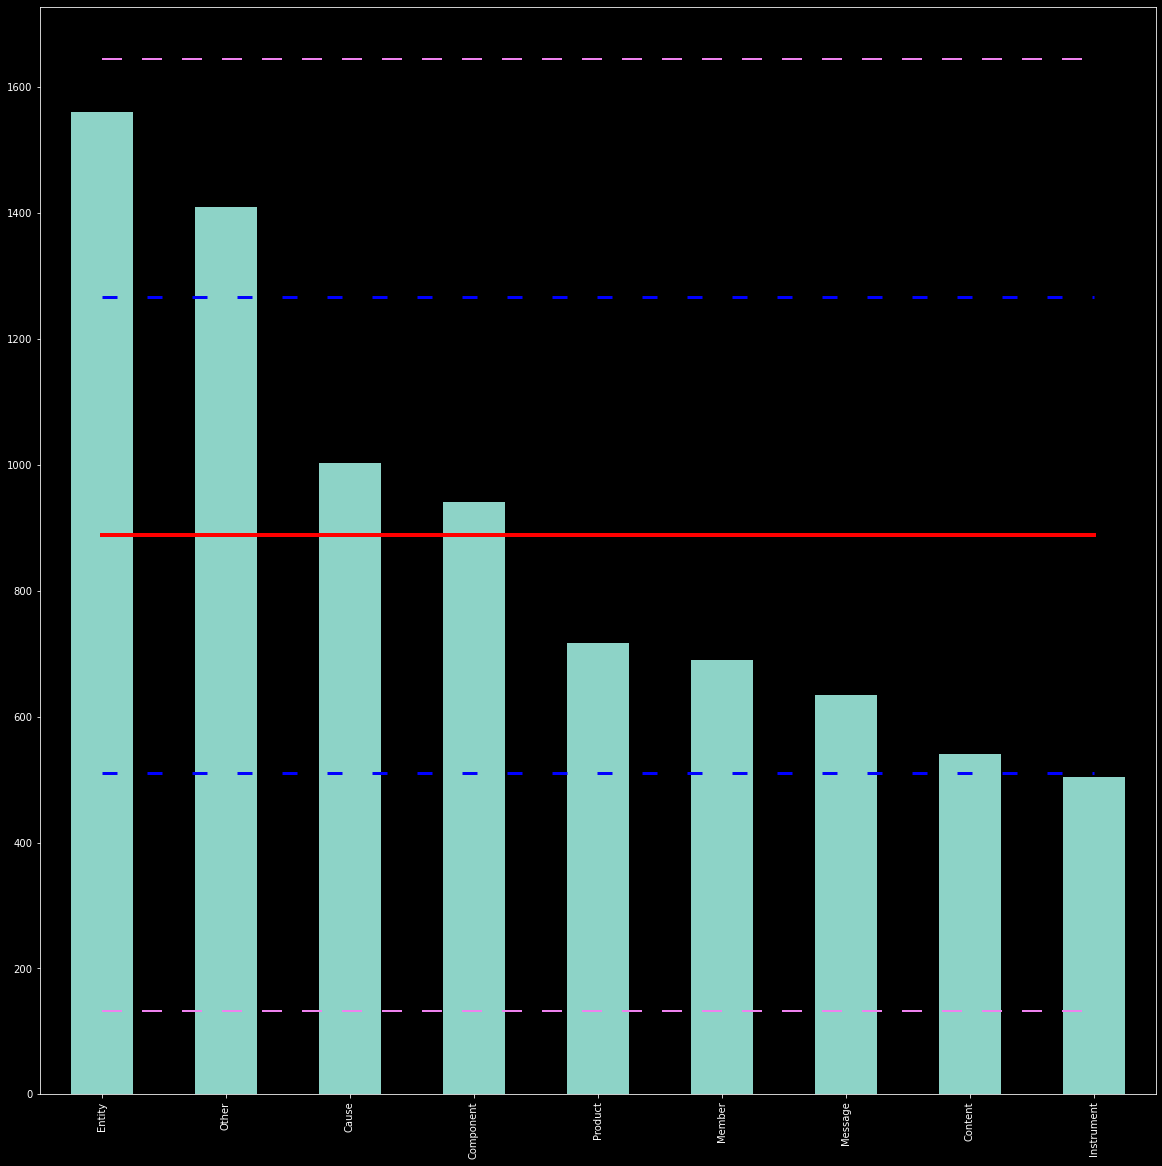

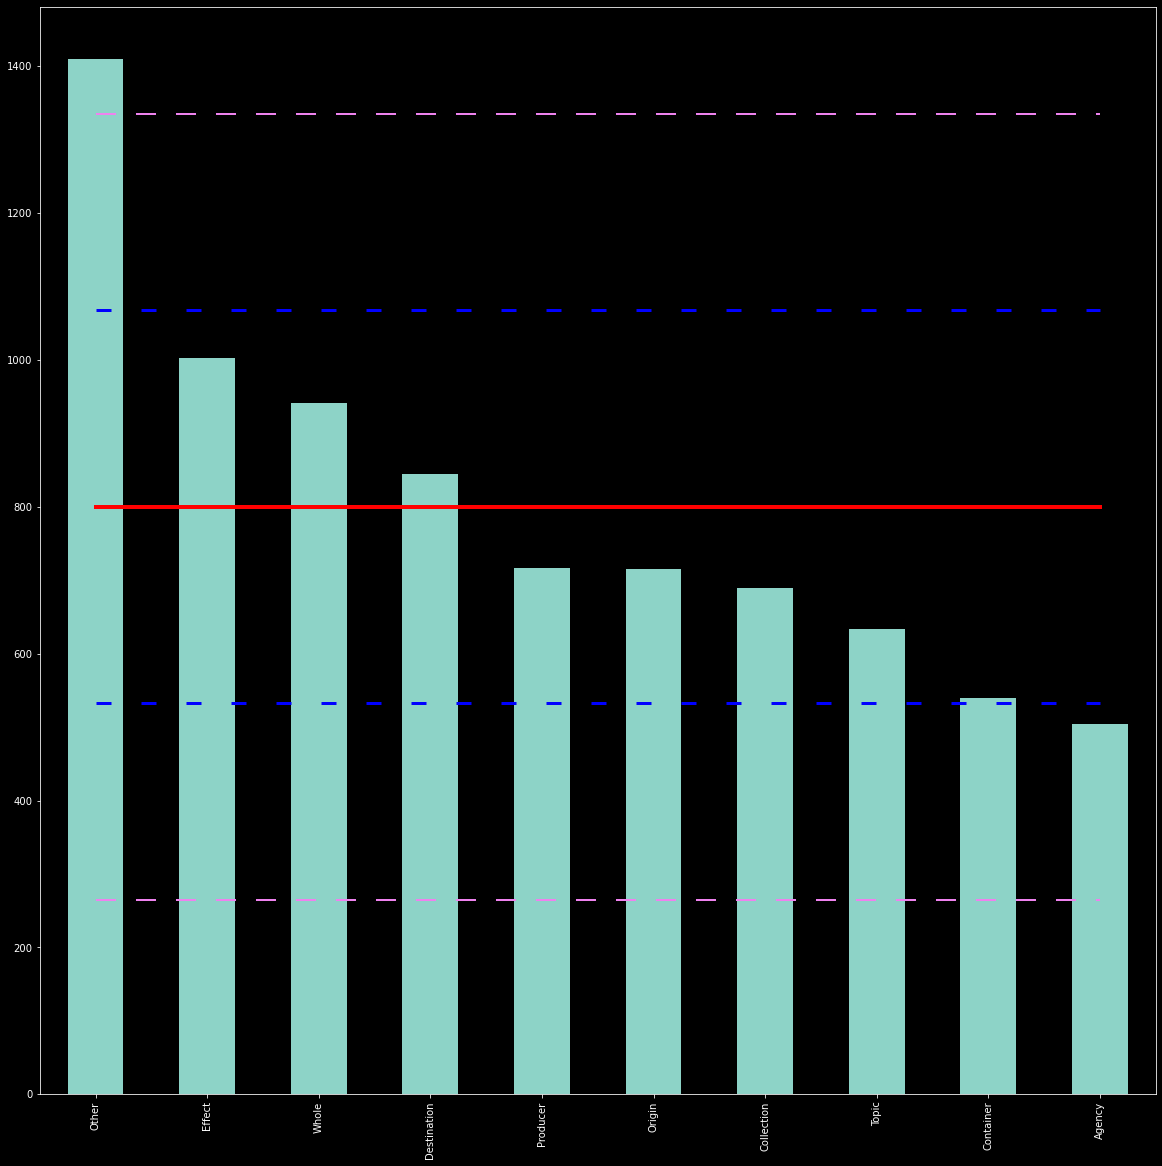

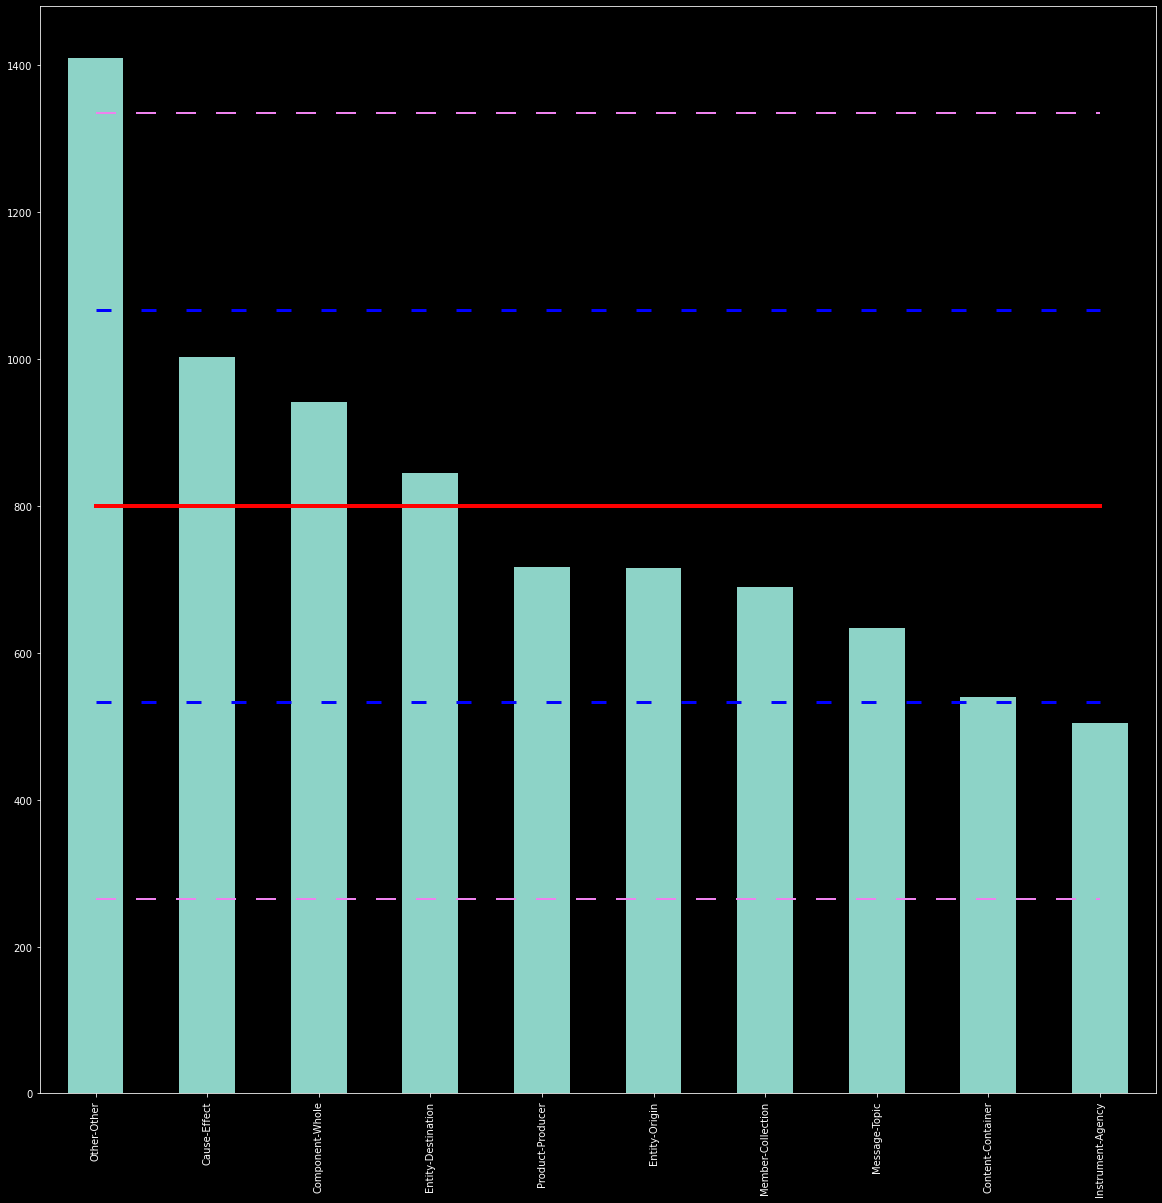

In [20]:
draw_dist(df_train)

Występuje podobna sytuacja jak w danych treningowych. Co gorsza, ilość możliwych relacji z typów argumentów relacji jest zatrważająco dużo większa, co oznacza, że występują zupełnie nowe typy relacji z `,,podrelacji''`. Model będzie zmuszony bardzo dobrze uogólniać wiedzę wykorzystując semantykę całego zdania, dlatego najprawdopodobniej ograniczymy się tylko do zbioru treningowego.

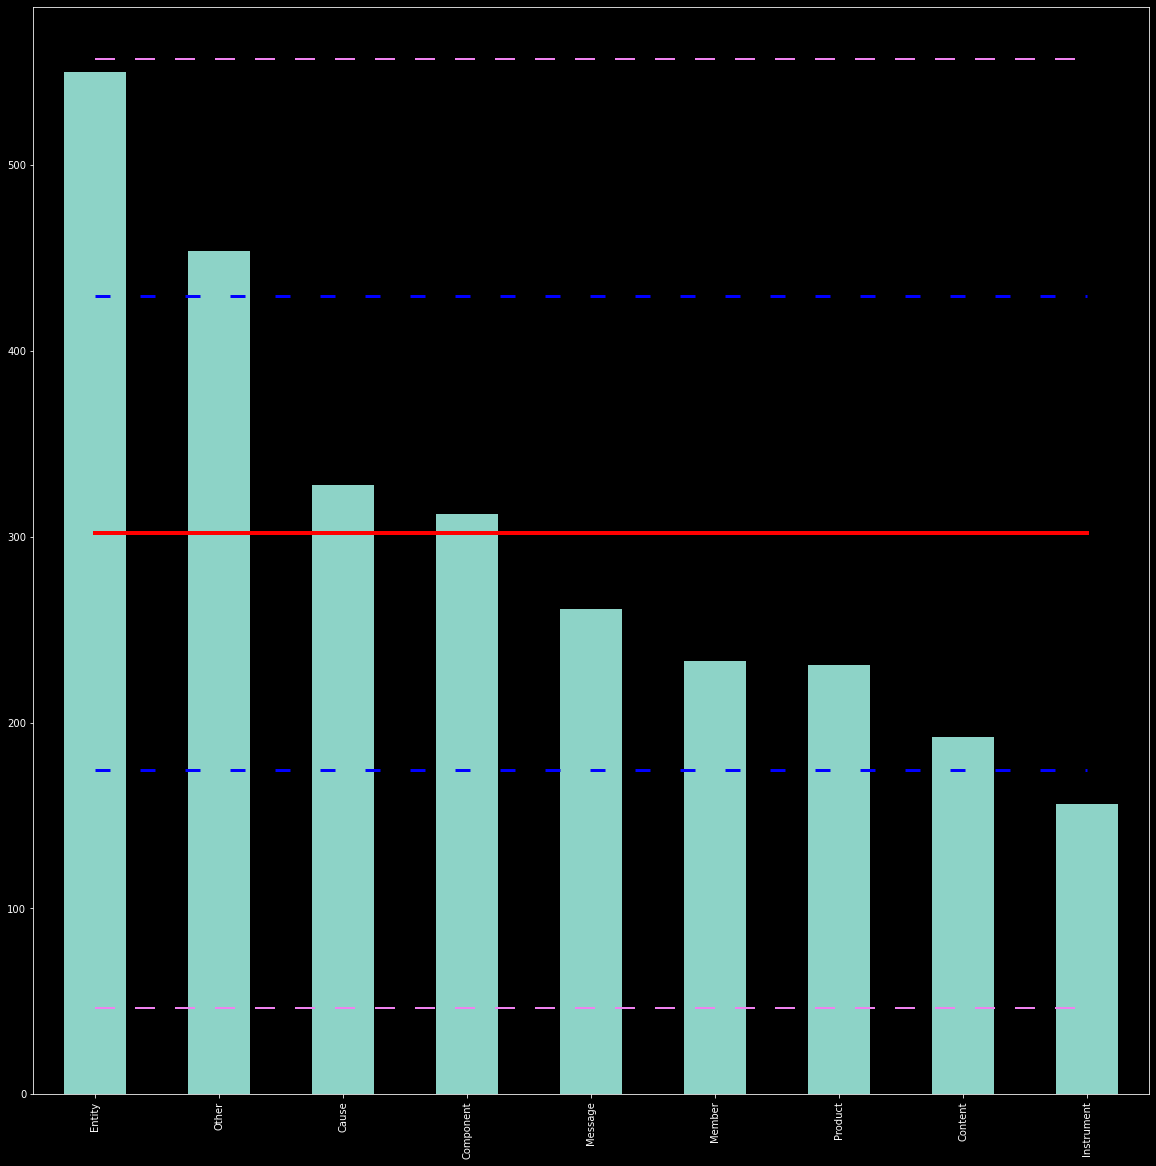

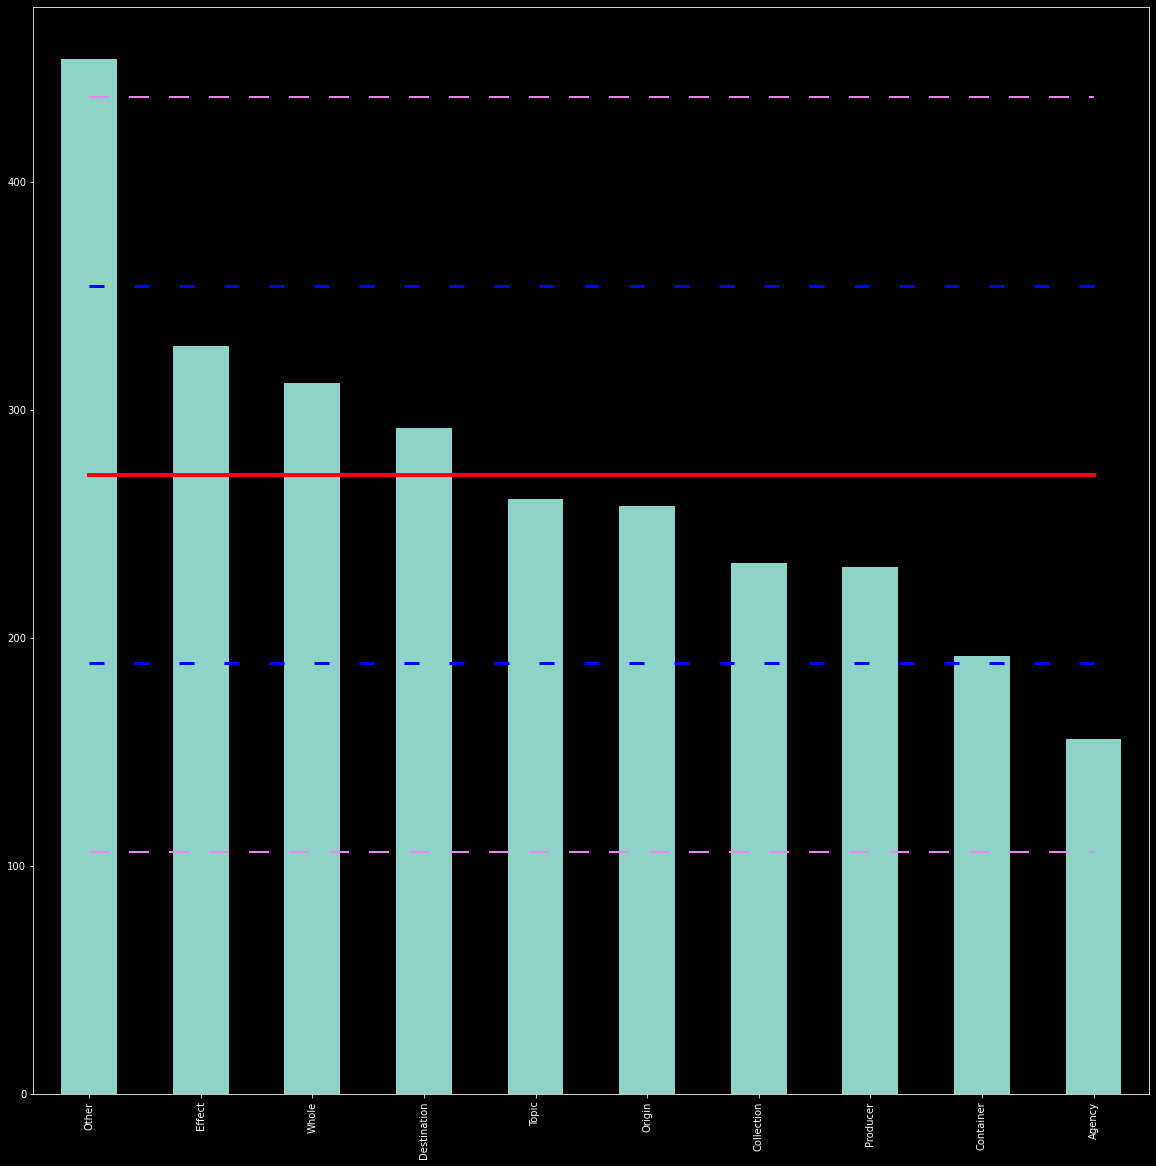

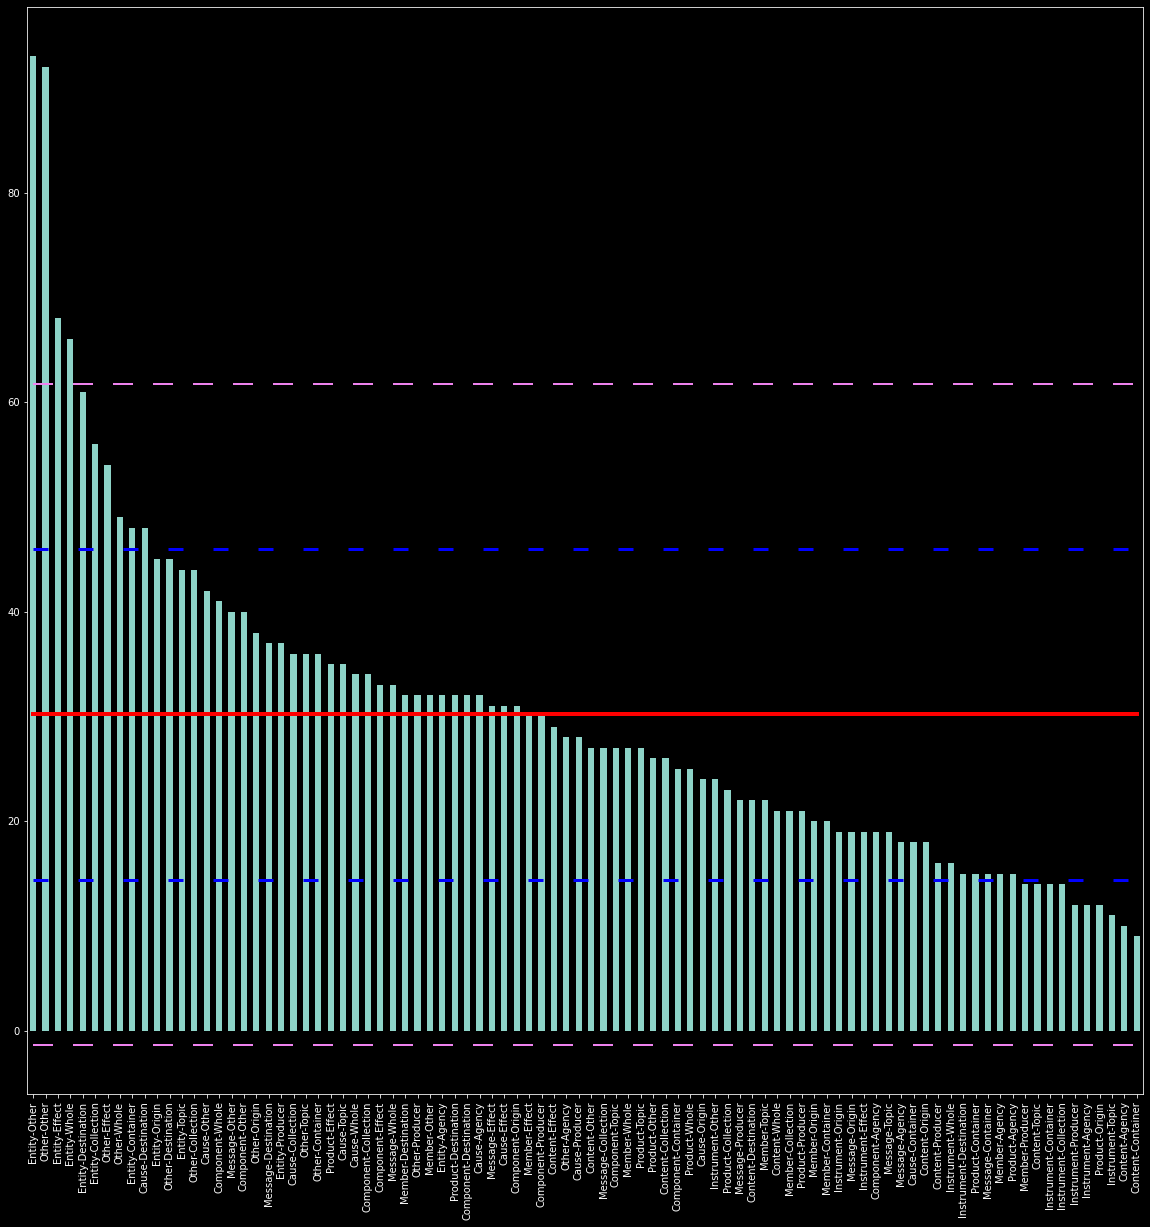

In [21]:
draw_dist(df_test)

# Przetwarzanie zbioru

In [26]:
from googletrans import Translator
from tqdm.notebook import tqdm

tqdm.pandas()

def translate(dataset: pd.DataFrame) -> pd.DataFrame:
    translator = Translator()
    dataset['text_pl'] = dataset['text'].progress_apply(lambda r: translator.translate(r, src='en', dest='pl'))
    dataset['text_pl'] = dataset['text_pl'].apply(lambda r: r.text)
    return dataset

In [6]:
df_train = translate(df_train)
df_train

In [7]:
df_test = translate(df_test)
df_test

,arg1_rel,arg2_rel,arg1,arg2,text,text_pl
0,Message,Topic,e1,e2,The most common <e1>audits</e1> were about <e2...,Najczęstsze <e1>kontrole</e1> dotyczyły <e2>od...
1,Product,Producer,e2,e1,The <e1>company</e1> fabricates plastic <e2>ch...,<e1>Firma</e1> produkuje plastikowe <e2>krzesł...
2,Instrument,Agency,e2,e1,The school <e1>master</e1> teaches the lesson ...,Szkolny <e1>mistrz</e1> prowadzi lekcję za pom...
3,Entity,Destination,e1,e2,The suspect dumped the dead <e1>body</e1> into...,Podejrzany wrzucił martwe <e1>ciało</e1> do lo...
4,Cause,Effect,e2,e1,Avian <e1>influenza</e1> is an infectious dise...,Ptasia <e1>grypa</e1> to choroba zakaźna ptakó...
...,...,...,...,...,...,...
2712,Instrument,Agency,e2,e1,"After seating all the idols, which itself take...","Po posadzeniu wszystkich bożków, co samo zajmu..."
2713,Product,Producer,e1,e2,The minister attributed the slow production of...,Minister przypisał powolną produkcję <e1>mater...
2714,Component,Whole,e2,e1,The <e1>umbrella</e1> <e2>frame</e2> is provid...,<e1>parasol</e1> <e2>rama</e2> jest wyposażona...
2715,Product,Producer,e1,e2,Manos: The Hands of Fate is a low-budget horro...,Manos: The Hands of Fate to niskobudżetowy <e1...


In [8]:
df_train.to_csv('semeval_train.csv', index=False)
df_test.to_csv('semeval_train.csv', index=False)

# Postprocessing

Usuwamy błędnie przetłumaczone przykłady, przez błędne rozumiemy pomieszane znaczniki etykiety.

In [8]:
import pandas as pd
from tqdm.notebook import tqdm
import re

tqdm.pandas()

def postprocessing(name: str):

    df = pd.read_csv(name)
    begin = r'\<e\d+\>'
    end = r'\</e\d+\>'
    inner_text = rf'(?:(?!{begin}).)*'
    pattern_tag = re.compile(fr'({begin})({inner_text})({end})')

    ents_pl = df['text_pl'].progress_apply(pattern_tag.findall)
    ents_en = df['text'].progress_apply(pattern_tag.findall)

    df['valid'] = True

    for doc_index, (pl, en) in enumerate(zip(ents_pl, ents_en)):
        if len(pl) != len(en):
            df.loc[doc_index, 'valid'] = False
        else:
            for p in pl:
                tag_start = p[0]
                text = p[1]
                tag_end = p[2]

                tag_start_letter = tag_start[1]
                tag_start_number = tag_start[2:-1]
                tag_end_letter = tag_end[2]
                tag_end_number = tag_end[3:-1]

                if not(all([
                    tag_start_letter == tag_end_letter,
                    tag_start_number == tag_end_number
                ])):
                    df.loc[doc_index, 'valid'] = False

    
    print(df['valid'].value_counts(True))

    df[df['valid']]\
        .drop(columns=['valid'])\
        .to_csv(f'fix_{name}', index=False)

In [9]:
postprocessing('semeval_test.csv')
postprocessing('semeval_train.csv')

  0%|          | 0/2717 [00:00<?, ?it/s]

  0%|          | 0/2717 [00:00<?, ?it/s]

True     0.991535
False    0.008465
Name: valid, dtype: float64


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

True     0.988875
False    0.011125
Name: valid, dtype: float64
